# Data Ingestion Pipeline

### Loading npy(s)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [2]:
processed_dataset  = "processed_data"

In [3]:
from scipy.ndimage import zoom
import os

# numero di sample richiesti
N = len(next(os.walk("%s/voxelizations" % processed_dataset))[2])


# carico il training set
print("Caricamento training set...")

voxelizations      = []
voxelization_specs = []
centers_of_mass    = []
finger_prints      = []
anchors            = []

for i in range(N):
    voxelization       = jnp.array(np.load("%s/voxelizations/voxelization_%d.npy"           % (processed_dataset,i)))
    voxelization_spec  = jnp.array(np.load("%s/voxelization_specs/voxelization_spec_%d.npy" % (processed_dataset,i)))
    center_of_mass     = jnp.array(np.load("%s/centers_of_mass/center_of_mass_%d.npy"       % (processed_dataset,i)))
    finger_print       = jnp.array(np.load("%s/finger_prints/finger_print_%d.npy"           % (processed_dataset,i)))
    anchor             = jnp.array(np.load("%s/anchors/anchor_%d.npy"                       % (processed_dataset,i)))
    
    voxelization_specs.append(voxelization_spec)
    voxelizations.append(voxelization)
    centers_of_mass.append(center_of_mass)
    finger_prints.append(finger_print)
    anchors.append(anchor)
    
    if int( i / (N / 10)) != int( (i + 1)/ (N/10) ):
        print("%d su %d" % (i , N))

Caricamento training set...
30 su 301
60 su 301
90 su 301
120 su 301
150 su 301
180 su 301
210 su 301
240 su 301
270 su 301
300 su 301


# Train Test Split

In [4]:
indici_train = np.arange(len(voxelizations)) < int(len(voxelizations) * .8)
indici_test  = ~indici_train         

# Subvoxelgrid Transform
Che tipo di trasformazione bisogna applicare alla subvoxel grid estratta prima di utilizzarla?

In [5]:
np.random.seed(123)
testA = np.random.randn(30,30,30)

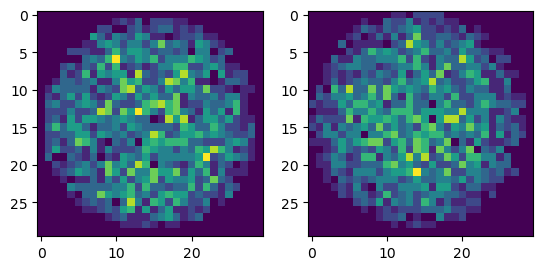

In [52]:
%matplotlib inline
class SubvoxelgridTransform:
    def __init__(self,n):
        self.grid = self._init_grid(n)
        self.ball = self._emptyball(n)
    
    def _init_grid(self,n):
        return np.array(
        [
            [
                [
                    [x,y,z]
                    for z  in np.linspace(-1,1,2*n)
                ]
                for y  in np.linspace(-1,1,2*n)
            ]
            for x  in np.linspace(-1,1,2*n)
        ]
        )

    def _emptyball(self,n):
        r = np.array([
            [
                [
                        (i**2 + j**2 + k**2) < 1
                    for k in np.linspace(-1,1,2*n)
                ]
                for j in np.linspace(-1,1,2*n)
            ]
            for i in np.linspace(-1,1,2*n)
        ])
        return r
    
    ##############################################################################################
    
    def identity(self,SV):
        return SV
    
    
    def random_rotation(self,points):
        A = np.random.randn(3,3)
        A = A @ A.T
        U,s,Vt = np.linalg.svd(A,full_matrices = False)
        points = points @ Vt.T
        return points
    
    def rotational_invariance(self,SV):
        # calcolo i nuovi punti        
        points = self.grid[ (SV * self.ball) > 0.5].reshape(-1,3)
        if len(points) < 2.:
            # non ci sono atomi nella selezione!
            return SV

        mu     = points.mean(axis = 0)
        #print(points.max(axis = 0), points.min(axis = 0))
        
        points = points - points.mean(axis = 0)
  
            
        # copio i punti originali
        original_points = points.copy()
        
        U,s,Vt = np.linalg.svd(points)
        
        

        projection = points @ Vt.T


        
        classifica = np.argmax( np.abs(projection), axis = 0)
        S  =   np.sign( projection[classifica,[0,1,2]] )
        V  =   S[None,:] * Vt.T
        points = points @ V
          
        
        ## costruisco la voxelgrid
        ret  = np.zeros(self.grid.shape[:-1])
        #stdpoints = (points - points.min(axis = 0)[None,:]) / (points.max(axis = 0) - points.min(axis = 0))[None,:]
        #stdpoints  = (points - points.min(axis = 0)[None,:] + 1e-9)/(points.max(axis = 0)[None,:] - points.min(axis = 0)[None,:] + 1e-9)
        
        points = points + mu @ V
        
        #print( points.max(axis = 0), points.min(axis =0 ))
        for p in points:
                #print(p)=
                i = (int(p[0] * ((SV.shape[0] - 1)/2.) +  (SV.shape[0] - 1)/2.))
                j = (int(p[1] * ((SV.shape[1] - 1)/2.) +  (SV.shape[1] - 1)/2.))
                k = (int(p[2] * ((SV.shape[2] - 1)/2.) +  (SV.shape[2] - 1)/2.))
                ret[i,j,k] = 1.
        return ret

A = testA.copy() #np.random.uniform(size = (30,30,30))
axs = plt.figure().subplots(nrows = 1,ncols = 2).flatten()
axs[0].imshow(( (A >0.99) * SubvoxelgridTransform(15).ball).mean(axis = 0))
axs[1].imshow(SubvoxelgridTransform(15).rotational_invariance(A > .99).mean(axis = 0))

# Batch extraction

In [32]:
def extract_dataset(N = 150,window_size = 8):
    X_train,F_train,Y_train = [],[],[]
    X_test ,F_test ,Y_test  = [],[],[]
     
    selezionati_train = np.random.choice(
                            np.arange(                 # isolo gli indici interi riguardandi    
                                len(voxelizations)     # il training set
                            )[indici_train] , size = N
                        )
    selezionati_test = np.random.choice(
                            np.arange(                 # isolo gli indici interi riguardandi
                                len(voxelizations)     # il test set
                            )[indici_test] , size = N  
                        )
    
    ####  Invarianza rotazionale
    
    transform = SubvoxelgridTransform(window_size)
    
    ##### TRAIN
    for sample in selezionati_train:
        curr_vox        = voxelizations[sample]
        x_min,x_max,y_min,y_max,z_min,z_max = curr_vox_specs  = voxelization_specs[sample]
        
        i,j,k    = np.array([
                            np.random.choice(q)
                        for q in curr_vox.shape
                   ])          # centro della subvoxel grid in termini di indici
        
        x,y,z    = (
                        (1. *i)/curr_vox.shape[0] * (x_max - x_min) + x_min,
                        (1. *j)/curr_vox.shape[1] * (y_max - y_min) + y_min,
                        (1. *k)/curr_vox.shape[2] * (z_max - z_min) + z_min
                   ) 
        center   = np.array([x,y,z])
        
        curr_vox = np.pad(curr_vox, 
                          pad_width = ((window_size,window_size),(window_size,window_size),(window_size,window_size))
                         )
        X_train.append( transform.rotational_invariance 
                        (
                           curr_vox[ 
                            (i+window_size) - window_size: (i+window_size) + window_size,
                            (j+window_size) - window_size: (j+window_size) + window_size,
                            (k+window_size) - window_size: (k+window_size) + window_size
                          ] 
                        )
                      )
        F_train.append(finger_prints[sample])
        Y_train.append( np.sum((center  - centers_of_mass[sample])**2) )
    
    
    #### TEST
    for sample in selezionati_test:
        curr_vox        = voxelizations[sample]
        x_min,x_max,y_min,y_max,z_min,z_max = curr_vox_specs  = voxelization_specs[sample]
        
        i,j,k    = np.array([
                            np.random.choice(q)
                        for q in curr_vox.shape
                   ])          # centro della subvoxel grid in termini di indici
        
        x,y,z    = (
                        (1. *i)/curr_vox.shape[0] * (x_max - x_min) + x_min,
                        (1. *j)/curr_vox.shape[1] * (y_max - y_min) + y_min,
                        (1. *k)/curr_vox.shape[2] * (z_max - z_min) + z_min
                   ) 
        center   = np.array([x,y,z])
        
        curr_vox = np.pad(curr_vox, 
                          pad_width = ((window_size,window_size),(window_size,window_size),(window_size,window_size))
                         )
        X_test.append( 
                        transform.rotational_invariance 
                        (
                            curr_vox[ 
                                (i+window_size) - window_size: (i+window_size) + window_size,
                                (j+window_size) - window_size: (j+window_size) + window_size,
                                (k+window_size) - window_size: (k+window_size) + window_size
                              ] 
                        )
                        )
        F_test.append(finger_prints[sample])
        Y_test.append( np.sum((center  - centers_of_mass[sample])**2) )        
        
    return (jnp.array(X_train),jnp.array(F_train),jnp.array(Y_train)), (jnp.array(X_test),jnp.array(F_test),jnp.array(Y_test))

# Reward

In [33]:
def predict(W,Wf,X,F):
    O     = (
         jnp.linspace(-int(W.shape[0]/2),int(W.shape[0]/2),W.shape[0])[:,None,None]**2 +
         jnp.linspace(-int(W.shape[1]/2),int(W.shape[1]/2),W.shape[1])[None,:,None]**2 +
         jnp.linspace(-int(W.shape[2]/2),int(W.shape[2]/2),W.shape[2])[None,None,:]**2    
    ) < 4.
    Y_hat = jax.vmap(lambda x,f: (x*(W + O*(f @ Wf))).sum())(X,F)
    return Y_hat

def protopredict(W,X):
    return jax.vmap(lambda x: (x * W).sum())(X)

def corr(x,y):
    return ((x - x.mean())@(y - y.mean()))/(jnp.linalg.norm(x - x.mean())*jnp.linalg.norm(y - y.mean()))
def reward(W,Wf,X,F,Y):
    Y_hat = predict(W,Wf,X,F)
    return corr(Y_hat,Y)
reward = jax.jit(reward)
grad   = jax.jit(jax.grad(reward, argnums = (0,1)))

# $ \hat Y( {\bf X} , {\bf f}) = \sum_i \sum_j \sum_k \left( {\bf X} \odot \left( {\bf W} + {\bf O}({\bf f}^T{\bf W_f} ) \right) \right)_{ijk}$ <br>

# Computational Loop

L'idea é quella di utilizzare una <b> ascesa del gradiente stocastica </b> per massimizzare la correlazione tra l'output del modello e la distanza al quadrato tra il <b> punto che rappresenta il centro della voxelgrid selezionata e il punto effettivo di attachment del ligando </b>.
Il modello prende in ingresso 
1. la subvoxelgrid centrata nel punto di cui si vuole valutare la bontá
2. la finger print del ligando
I parametri $\theta$ sono rappresentati da un tensore ${\bf W}$ che agisce come un funzionale lineare nello spazio delle subvoxelgrid di ordine $n$ e un vettore ${\bf W_f}$ che agisce invece come funzionale nello spazio delle fingerprint

In [34]:
%matplotlib qt5

In [35]:
window = 8                # grandezza della finestra
np.random.seed(123)       # fisso il seed per la riproducibilitá 
W      = np.random.normal(size = (2*window,2*window,2*window))
Wf     = np.random.normal(size = 2048) * 1e-5 # small!
plt.figure()

# dati del grafico

validation_scores = []

# ciclo di calcolo

for i in range(1000):
    (X_train_curr, F_train_curr,Y_train_curr) , (X_test_curr, F_test_curr,Y_test_curr) = extract_dataset(window_size=window)
    g  = grad(W,Wf,X_train_curr,F_train_curr,Y_train_curr)
    W  += 1e-1 * g[0]
    Wf += 1e-1 * g[1]
    print( i, reward(W,Wf,X_train_curr,F_train_curr,Y_train_curr), reward(W,Wf,X_test_curr,F_train_curr,Y_test_curr)  )
   
    validation_score = reward(W,Wf,X_test_curr,F_train_curr,Y_test_curr)
    validation_scores.append(validation_score)
    
    plt.scatter(i, validation_score, s = 50., color = 'black')
    if i % 10 == 0:
        plt.show()
        plt.pause(1e-12)

0 -0.17745791 0.08275505
1 -0.044404995 0.008251746
2 0.013037342 -0.08072216
3 -0.12090081 -0.19745937
4 -0.10378467 -0.049955618
5 0.00025479155 -0.07730079
6 -0.027282199 -0.041923724
7 -0.08175293 0.1450987
8 -0.15200995 0.02724788
9 0.020987196 -0.06594847
10 -0.08295019 -0.13137208
11 -0.16028407 0.003609653
12 0.16654977 -0.13445525
13 0.023616863 -0.08249801
14 0.100976445 0.09517026
15 -0.030596912 0.036439314
16 -0.008326575 0.07829373
17 0.113541886 -0.030870566
18 -0.008444369 0.078750014
19 0.08118959 0.07041596
20 -0.08233404 0.17719783
21 -0.08170173 0.035699796
22 0.007492655 0.12849997
23 0.16411193 0.13053644
24 0.05131354 -0.00452382
25 0.17135058 0.05627563
26 0.11207168 0.14854538
27 0.1615702 0.0878499
28 0.044715416 -0.049806472
29 0.043289848 -0.025487697
30 0.036916714 0.08672157
31 0.009365191 0.15081419
32 0.12121341 0.0952041
33 0.103007525 0.060901735
34 -0.06480905 0.04952104
35 0.016821744 0.07633211
36 -0.023856403 -0.07150215
37 0.09702473 0.021662064
3

313 0.30076158 -0.0022038494
314 0.084257364 0.14307763
315 0.2264703 0.09021606
316 0.25927678 0.11072442
317 0.19531773 0.05455617
318 0.2138629 0.14255674
319 0.2372952 0.20052414
320 0.2742704 0.23947482
321 0.20555393 0.16632889
322 0.21621674 0.101780035
323 0.19332469 0.15508153
324 0.1644621 0.2324128
325 0.2681227 0.18091798
326 0.20141974 0.0351123
327 0.31465507 0.12145511
328 0.16963023 0.15276627
329 0.11988891 0.15406771
330 0.2070296 0.17610474
331 -0.028377546 0.14124021
332 0.3356069 0.03735158
333 0.12611297 0.10222095
334 0.25385863 0.20789604
335 0.17956215 0.12250407
336 0.087043695 0.13913774
337 0.28922048 0.11533148
338 0.25194845 0.14930367
339 0.19877665 -0.04758934
340 0.31747374 0.18492256
341 0.15342811 0.13611779
342 0.24055307 0.19241261
343 0.2549953 0.16866967
344 0.197924 0.07447428
345 0.26503018 0.14478828
346 0.0977636 0.2766892
347 0.20876044 0.13569005
348 0.31209847 0.2181248
349 0.1541704 0.044419818
350 0.15037538 0.22408772
351 0.27341586 0.24

632 0.22630237 0.40473363
633 0.25542277 0.1644878
634 0.3263928 0.026168302
635 0.2847597 0.11463929
636 0.27509746 0.28808153
637 0.28006786 0.25573656
638 0.2930631 0.12454009
639 0.26428452 0.0068262643
640 0.28435263 0.32004774
641 0.25179496 0.092229486
642 0.31834075 0.30675122
643 0.12967254 0.17544933
644 0.3264111 0.247742
645 0.2521345 0.19803159
646 0.35462877 0.14641628
647 0.29218072 0.15208432
648 0.35721186 0.23568521
649 0.2878367 0.11886433
650 0.16308998 0.07926496
651 0.23992011 0.15972823
652 0.23095027 0.2566527
653 0.31828287 0.25768566
654 0.19124012 0.33522514
655 0.3366609 0.1572592
656 0.29606465 0.3378903
657 0.18749024 0.27423444
658 0.23699333 0.21586326
659 0.20413761 -0.03558029
660 0.24498764 0.107684016
661 0.19146864 0.22572584
662 0.21460503 0.19135983
663 0.18179308 0.24877268
664 0.19157727 0.2598717
665 0.20358823 0.23478438
666 0.21000269 0.19151266
667 0.27326703 0.15645649
668 0.13541876 0.19819902
669 0.25931475 0.014056519
670 0.34260553 0.14

952 0.31198928 0.2278597
953 0.268006 0.23771241
954 0.24398527 0.14868398
955 0.3216183 0.26582092
956 0.33616632 0.23471898
957 0.39185494 0.23800714
958 0.34837794 0.14951341
959 0.3301027 0.22523582
960 0.2618635 0.06420218
961 0.28982228 0.20957923
962 0.28031787 0.19961847
963 0.23383757 0.2377097
964 0.2838521 0.25837693
965 0.38277677 0.22449338
966 0.29520765 0.314765
967 0.22889805 0.19828054
968 0.17715001 0.106370516
969 0.35869288 0.10330167
970 0.36629182 0.23857366
971 0.19975562 0.24356194
972 0.40431538 0.1903157
973 0.34684238 0.15088098
974 0.17189142 0.15301538
975 0.32587507 0.25302505
976 0.39103338 0.2416548
977 0.33698687 0.2154183
978 0.33119494 0.29697022
979 0.2276397 0.3195266
980 0.35090274 0.15693378
981 0.28641057 0.032250248
982 0.34630805 0.29177284
983 0.2611396 0.17898244
984 0.23027909 0.16935383
985 0.2379722 0.09270966
986 0.31577927 0.02061694
987 0.29855168 0.24800125
988 0.3354352 0.23660946
989 0.22864045 0.23322538
990 0.25659627 0.2888158
991

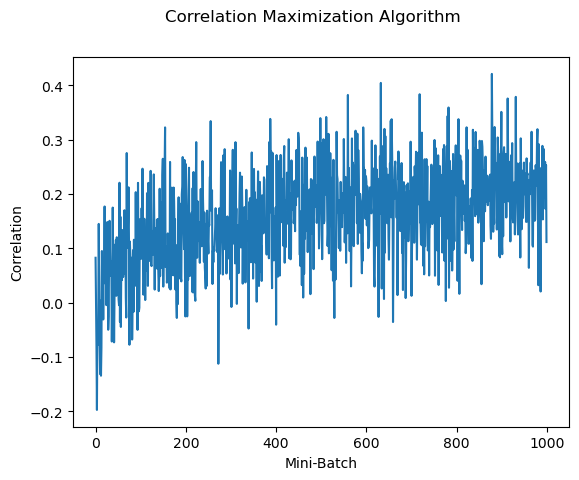

In [36]:
%matplotlib inline
plt.suptitle("Correlation Maximization Algorithm")
plt.ylabel("Correlation")
plt.xlabel("Mini-Batch")
plt.plot(validation_scores)

# Salvo i pesi

In [37]:
np.save("W_fine_shorter_2712_%d.npy" % window, W)
np.save("Wf_fine_shorter_2712_%d.npy" % window, Wf)

# Carico i pesi

In [43]:
window = 15
W  = np.load("W_fine_%d.npy" % window)
Wf = np.load("Wf_fine_%d.npy" % window)

# Test (singolo)

Data una voxelizzazione carico gli anchor point e ne calcolo la distanza con il punto di attachment.
Per testare la bontá del classificatore precedente viene analizzata la correlazione tra l'output e la distanza effettiva

-197.21344 8.039377
-94.60867 51.78057
-128.58151 197.33151
-39.64074 285.77292
35.20381 75.14566
-60.06093 104.8634
-110.47331 115.91579
-47.02648 207.36038
-183.11925 41.085754
-49.05802 283.72473
-84.16849 51.001167
23.505407 240.13365
-39.806644 332.10544
-29.518269 338.6125
8.634371 189.34235
-82.31894 92.51673
-36.27214 464.2707
-4.3624573 191.40572
-37.555386 348.406
5.4707026 414.13562
-40.169647 224.64655


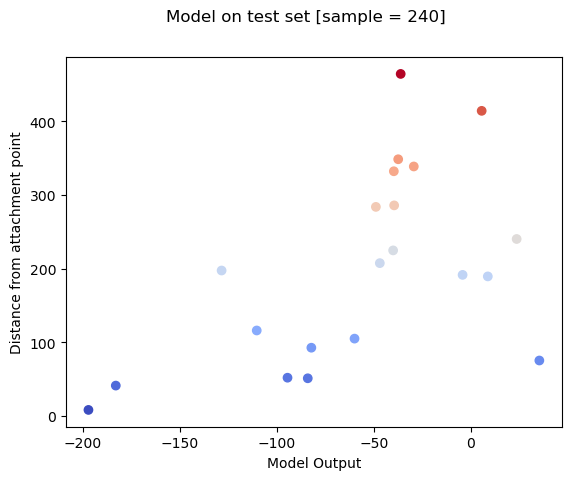

In [46]:
sample = np.arange(len(voxelizations))[indici_test][0]

protoprediction = False # se settato a True effetta la predizione senza contare la fingerprint

def prediction_compare(sample):
    # dato un sample ritorna una matrice la cui prima colonna
    # rappresenta l'output del modello mentre la seconda
    # é la vera "inadeguatezza" degli anchor point
    
    
    # costrusico la voxgrid paddata
    Nx,Ny,Nz  = voxelizations[sample].shape
    curr_vox  = jnp.pad(
                    voxelizations[sample],
                    pad_width = (
                        (window,window),
                        (window,window),
                        (window,window)
                    )
                )

    # imposto la trasfromazione

    transform = SubvoxelgridTransform(window)

    points = []
    for a in anchors[sample]:
       
        correct_distance = jnp.sum( ( a - centers_of_mass[sample] )**2 )

        # trovo il voxel associato al punto di ancoraggip
        x_min,x_max,y_min,y_max,z_min,z_max = voxelization_specs[sample]
        x,y,z = a
        i,j,k = (
                 int( (x - x_min)/(x_max - x_min) * Nx ),
                 int( (y - y_min)/(y_max - y_min) * Ny ),
                 int( (z - z_min)/(z_max - z_min) * Nz )
        )

        # estraggo la subvoxelgrid
        
        subvox = transform.rotational_invariance(curr_vox[ 
                                (i+window) - window: (i+window) + window,
                                (j+window) - window: (j+window) + window,
                                (k+window) - window: (k+window) + window
                              ])
    
        # estraggo il farmaco
        f      = finger_prints[sample]
        if protoprediction:
            Y_hat =  protopredict(W,subvox[None,:])[0]
        else:
            Y_hat =  predict(W,Wf,subvox[None,:],f[None,:])[0]
        
        print(Y_hat,correct_distance)
        points.append([Y_hat,correct_distance])
    points = np.array(points)
    return points

points = prediction_compare(sample)
plt.xlabel("Model Output")
plt.ylabel("Distance from attachment point")
plt.suptitle("Model on test set [sample = %d]" % sample)
plt.scatter(points[:,0],points[:,1],c = points[:,1], cmap = 'coolwarm')

Si osservi come l'output del calssificatore sia effettivamente in grado di "correlare" con la distanza effettiva (punti vicini al punto di ancoraggio producono un output piccolo)

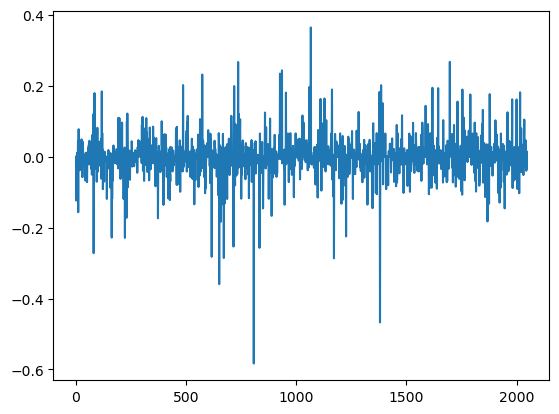

In [120]:
plt.plot(Wf)

# Esempio

In [124]:
def norme_subvoxelgrids(sample):
    # dato un sample ritorna una matrice la cui prima colonna
    # rappresenta l'output del modello mentre la seconda
    # é la vera "inadeguatezza" degli anchor point
    
    
    # costrusico la voxgrid paddata
    Nx,Ny,Nz  = voxelizations[sample].shape
    curr_vox  = jnp.pad(
                    voxelizations[sample],
                    pad_width = (
                        (window,window),
                        (window,window),
                        (window,window)
                    )
                )

    # imposto la trasfromazione

    transform = SubvoxelgridTransform(window)
    rets = []
    
    for a in anchors[sample]:
        correct_distance = jnp.sum( ( a - centers_of_mass[sample] )**2 )

        # trovo il voxel associato al punto di ancoraggip
        x_min,x_max,y_min,y_max,z_min,z_max = voxelization_specs[sample]
        x,y,z = a
        i,j,k = (
                 int( (x - x_min)/(x_max - x_min) * Nx ),
                 int( (y - y_min)/(y_max - y_min) * Ny ),
                 int( (z - z_min)/(z_max - z_min) * Nz )
        )

        # estraggo la subvoxelgrid
        subvox = curr_vox[ 
                                (i+window) - window: (i+window) + window,
                                (j+window) - window: (j+window) + window,
                                (k+window) - window: (k+window) + window
                              ]
        
        rets.append( (subvox *  W).sum() )
        print(a, rets[-1], correct_distance) 
    return 0

norme_subvoxelgrids(75)

[ 7.368 19.538 52.23 ] -14.217674 9.476288
[ 1.868 19.038 46.23 ] 15.133439 77.400345
[19.368 15.038 46.23 ] 6.2768326 140.31558
[13.368 15.538 56.23 ] -24.499298 73.32808
[17.368 21.538 41.73 ] 13.30327 134.68396
[ 2.368 15.538 58.73 ] 13.257339 147.12134
[ 8.368 13.038 42.23 ] -24.940039 119.442505
[ 3.868 25.038 59.23 ] 50.122627 135.09897
[-0.632 14.038 39.73 ] 10.51616 254.97336
[16.368 12.538 39.23 ] -1.9162169 228.76404
[ 9.868 26.038 46.73 ] 15.6547365 44.735023


0

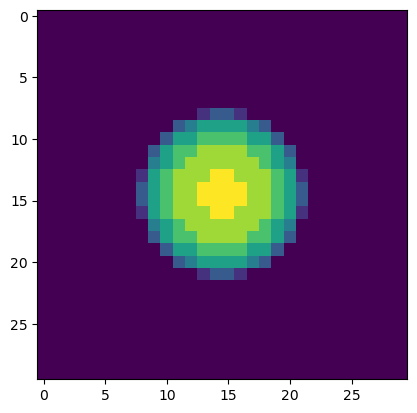

In [51]:
O     = (
     jnp.linspace(-int(W.shape[0]/2),int(W.shape[0]/2),W.shape[0])[:,None,None]**2 +
     jnp.linspace(-int(W.shape[1]/2),int(W.shape[1]/2),W.shape[1])[None,:,None]**2 +
     jnp.linspace(-int(W.shape[2]/2),int(W.shape[2]/2),W.shape[2])[None,None,:]**2    
) < (7)**2
plt.imshow(O.mean(axis = 0))

# Test Globale

Il nostro modello produce fondamentalmente una "classifica" di bontá degli anchor points.
Per valutare la bontá del modello produciamo una confusion matrix definita in questo modo

Dato un set di <b>Anchor Points</b> $A$ e u Definiamo $C_{A,t} : A \rightarrow \{0,1\}$ la funzione che restituisce $0$ se l'anchor point é tra i primi $t$ piú vicini al punto di attachment, viceversa $1$ se é tra gli ultimi $|A| - t$ per vicinanza. <br>
<br>
<i>
<b> Definizione </b> (buon anchor point): Dato un set di anchor points $A$ e una soglia $t \in [1,|A|]$, $a \in A$ é detto un <b> buon anchor point se nella $C_{A,t}(a) = 0$</b> 
</i>
<br>
<br>
Parallelamente definiamo $\hat C_{A,t} : A \rightarrow \{0,1\}$ la funzione che, analogamente, resituisce $0$ se l'anchor point in ingresso é <b> predetto dal modello </b> come tra i primi $t$ piú vicini, viceversa $1$ se é tra gli ultimi $|A| - t$ per vicinanza <b> predetta</b>


<br>
Per valutare la bontá del nostro modello possiamo considerare la matrice $M$ cosí definita
<br><br>
<center>
$M^{(t)}_{ij} = \mathbb P[ \hat C_{A,t}(a) = i | C_{A,t}(a) = j  ]$
</center>
<br>
Che ha come elementi sulla diagonale le probabilitá di dare un risultato corretto in funzione del vero set di appartenenza dell'anchor point

In [80]:
soglia = 8

<AxesSubplot:>

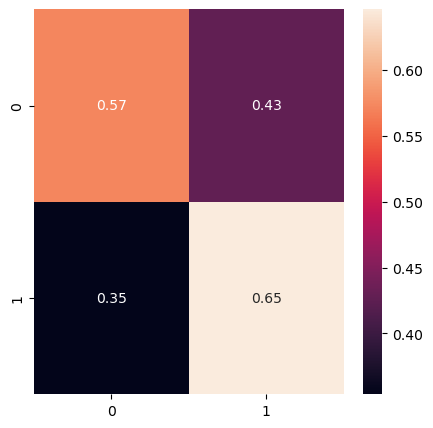

In [17]:
test_samples = np.arange(len(voxelizations))[indici_test]
M = np.zeros((2,2))

for sample in test_samples:
    #print("processing %d" % sample)
    points      = prediction_compare(sample)
    classifiche = points.argsort(axis = 0)
    for c in classifiche:
        i = c[0]
        j = c[1]
        if i >= soglia:
            i = 1
        else:
            i = 0
        if j >= soglia:
            j = 1
        else:
            j = 0
        M[i,j] += 1.

M = M / M.sum(axis = 0)[:,None]
        
import seaborn as sns
plt.figure(figsize = (5,5))
sns.heatmap(M, annot = True)
    

# Comparazione con Oracolo Randomico

Si definisce un <b>oracolo randomico</b> come una funzione $\mathscr O$ che prende in ingresso una <b> lista di anchor points </b> e restituisce <b> una classifica casuale </b>. <br>
Come ad esempio

In [18]:
def oracolo(A):
    classifica = np.random.choice(len(A),len(A),False)
    return classifica

Applichiamo lo stesso test globale sull'oracolo randomico per comparare le matrici di confusione

<AxesSubplot:>

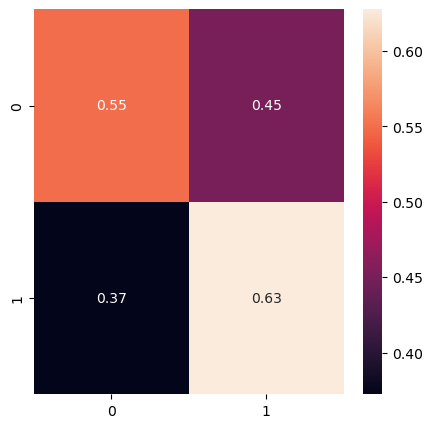

In [19]:
test_samples = np.arange(len(voxelizations))[indici_test]
M = np.zeros((2,2))

for sample in test_samples:
    #print("processing %d" % sample)
    points      = prediction_compare(sample)
    points[:,0] = oracolo(np.arange(len(points)))
    classifiche = points.argsort(axis = 0)
    for c in classifiche:
        i = c[0]
        j = c[1]
        if i >= soglia:
            i = 1
        else:
            i = 0
        if j >= soglia:
            j = 1
        else:
            j = 0
        M[i,j] += 1.

M = M / M.sum(axis = 0)[:,None]
        
import seaborn as sns
plt.figure(figsize = (5,5))
sns.heatmap(M, annot = True)
    

Si osservi che gli elementi sulla diagonale risultano inferiori rispetto all'esperimento basato sul modello. Questo a riprova del fatto che il modello é in grado di mappare buoni anchor point in predizioni positive

# One-choice Test

Un test piú intuitivo, che rappresenta meglio il caso di uso pratico dell'algoritmo é il <b> one-choice test </b>

<b> Definizione: </b> (One-choice test) Si definisce come One-choice il confronto tra le stime di probabilitá di selezionare un <b> buon anchor point </b> usando una policy casuale rispetto alla stima di probabilitá di selezionare un buon anchor point usando la policy definita implicitamente dal modello

<b> Definizione: </b> (Policy definita da un modello) Sia $\hat m$ un modello che prende in ingresso anchor points e restituisce una classifica. La policy definita dal modello ritorna con probabilitá $1$ il primo anchor point in classifica

<b> Remark </b> (Policy per un oracolo randomico) Dal momento che il modello rappresentato dall'oracolo randomico $\mathscr O$ restituisce una permutazione casuale degli anchor points come classifica, il primo in classifica é un anchor point casuale (con probabilitá di estrazione equidistribuita tra i vari anchor points)

Testiamo la bontá della predizione misurando la probabilitá che il migliore predetto dal modello sia tra i primi $t$.<br>
Definiamo lo stimatore $J$ tale che
<br><br>
<center>
$
J(\hat y)
\sim
\underbrace{
    \underset{a \in A}{\text{argmin}} \ \hat y(a) 
}_{\text{Selezionato dal modello}}    
   \in 
   \overbrace{ 
       A|_{C_{A,t}(A) = 0 }
   }^{
   \text{"Buoni" anchor point}
   }
$
</center>
Si osservi che <br>
<center>
    $\mathbb E[J(\hat y)] = \mathbb P [
    \underset{a \in A}{\text{argmin}} \ \hat y(a) 
   \in 
       A|_{C_{A,t}(A) = 0 }
]$
</center>

Chiamando nuovamente $\mathscr O$ l'oracolo randomico, vogliamo confrontare le variabili aleatorie $J(\hat y)$ e $J(\mathscr O)$<br> 
In particolare siamo interessati a valutare $\mathscr I(\hat y,\mathscr O) = J(\hat y) - J(\mathscr O)$  ovvero la variabile aleatoria che ci informa circa il miglioramento portato dal nostro algoritmo rispetto a una scelta casuale

In [130]:
test_samples = np.arange(len(voxelizations))[indici_test]

J = []
J_oracolo = []
print("Stimando J(y) e J(O)...")
for i,sample in enumerate(test_samples[np.random.choice(len(test_samples),size = 500,replace = True)]):
    print(i)
    points      = prediction_compare(sample)
    points      = points.argsort(axis = 0)
    scelto      = points[:,1][points[:,0].argmin()]
    curr_soglia = 2
    J.append( scelto < curr_soglia )
    scelto_rnd  = points[:,1][np.random.choice(len(points))]
    J_oracolo.append(scelto_rnd < curr_soglia)
print("Stima eseguita.")

Stimando J(y) e J(O)...
0
-112.198975 15.805211
-67.19382 236.22845
-116.80001 22.536377
-80.17104 97.50316
-84.54628 120.92752
-107.79411 135.1991
-71.48485 85.74059
-139.0828 398.39325
-74.83525 264.30396
-74.25127 383.27863
-134.55545 281.5826
-58.07917 279.62347
-74.12579 299.12122
-106.370316 162.87405
-78.36438 511.44843
-39.38411 509.33057
-55.998665 438.9406
-2.7972593 271.25583
-71.5611 340.29718
-44.320393 145.0312
-57.809822 388.4013
-75.788574 270.756
-8.94374 242.29066
-42.832687 447.2259
1
-73.98838 2.3502302
-80.8387 118.217834
-98.72832 152.85417
-130.40608 96.71681
-80.895996 119.49757
-103.94551 224.83517
-98.49092 63.134926
-74.72333 326.7986
-78.6926 291.05377
-73.53967 205.92487
-54.089893 334.6361
-43.005264 64.92032
-63.038795 109.16369
-38.958855 330.32327
2
-69.87536 1.8692706
-79.674255 116.973206
-114.758095 84.20931
-75.03916 153.06314
-66.77771 233.94812
-108.56914 320.4798
-72.129524 308.08096
-80.18367 62.569122
-92.709305 320.2647
-54.130558 192.8628
-38

-10.693084 146.1389
-3.4800067 700.00256
2.1937027 481.3747
2.2095194 308.1582
-2.2012038 79.64372
18.642937 156.50204
-11.088773 97.927155
-35.85528 237.90546
25
-72.73882 23.829247
-55.05878 76.791016
-51.48491 206.04027
-52.235504 221.75195
-30.817244 85.7436
-52.31151 120.43947
-30.624847 261.29303
-20.899239 184.81265
-58.34578 402.6501
-27.762306 383.15503
-55.24999 101.471504
-39.609325 344.89157
-72.83647 11.71401
-53.590374 206.04115
-12.984485 396.66187
-64.57137 399.94028
-12.149692 306.8398
-20.043722 480.8803
26
-55.666275 177.10486
-99.47652 317.5737
-76.497574 254.79492
-72.97539 245.9972
-100.136024 157.009
-59.781414 70.67429
-74.69871 20.232737
-65.349304 268.02432
-71.74338 325.56555
-53.894833 384.6803
-56.11523 307.21722
-80.786896 263.554
-61.38873 174.48407
-57.2734 179.45465
-46.332756 152.44437
-51.00959 22.132957
-62.55137 241.85286
-63.85882 374.8552
-58.07206 324.3847
-62.46348 452.19403
-29.423716 371.77066
-78.80246 436.7403
-68.07626 231.65454
-5.2396083 

-29.476196 329.6026
-44.824085 174.02579
-16.21792 243.92776
-30.429264 279.36246
-36.56637 361.24475
47
-115.500275 120.1575
-128.65686 198.60403
-61.8005 9.335639
-47.669647 155.96147
-107.04213 161.34392
-113.38829 119.14333
-97.72569 275.43326
-73.64305 277.23206
-58.010212 145.67911
-18.26049 256.64755
-47.135796 236.49501
48
-157.6409 135.46007
-110.00357 27.17644
-101.106316 67.78905
-125.42799 114.5686
-104.775826 176.50922
-102.483345 196.21024
-46.02469 156.96246
-99.22742 135.64131
-82.69323 157.95555
-65.8221 11.825205
-108.683655 93.41864
-95.5015 173.41269
-71.92122 78.86808
-86.89596 244.65192
49
-12.449529 49.86086
-49.49847 113.9751
-42.702057 71.44486
-9.220225 448.44116
-11.971792 22.764814
-12.349581 163.87943
31.323723 221.95807
-54.528778 200.37595
-13.483099 450.12048
-14.500105 59.632774
-9.290291 362.895
-35.98027 260.7564
-12.478423 176.49995
-34.329987 365.2079
9.603772 491.70132
4.665801 382.8296
-19.8824 189.3067
0.72129434 402.657
-10.693084 146.1389
-3.48

-33.41714 46.483234
-22.168732 45.511322
-35.735973 76.45189
-50.85538 85.05326
-2.474142 168.19162
-18.265007 135.42882
-11.306694 141.33319
-21.883844 233.18314
-6.8299484 221.78023
69
-65.83477 21.153534
-40.029675 138.64987
-56.344643 155.81346
-55.198303 297.22653
-20.533419 29.368244
-9.124241 199.45912
-40.115147 187.36852
-50.574417 162.73474
-27.182486 310.39432
-36.32583 23.551405
-4.5577383 94.47161
-57.962486 284.40814
-16.57471 429.2073
-16.775242 194.72485
-31.799572 340.62003
-61.48769 351.44568
-76.89309 232.33836
-7.1890936 210.85677
70
-143.05476 10.3389225
-89.42514 149.21696
-118.05423 247.12408
-71.95741 60.43937
-110.597916 291.50952
-102.19747 389.1404
-83.76445 43.780914
-80.87515 153.62724
-85.55838 127.08336
-98.27066 334.45917
-45.448357 113.22144
-51.14833 363.16687
-50.1829 97.2297
71
-132.09209 4.1484885
-72.97062 157.22012
-67.808655 189.88292
-69.02463 238.20078
-56.653152 315.16138
-103.27094 145.1369
-113.57022 88.0568
-37.873383 108.39442
-46.832375 5

-22.52058 89.2732
-12.574724 104.07404
96
-27.171339 11.145968
-70.14842 248.67514
-39.871796 268.82684
-61.941696 99.28118
-108.84442 32.20505
-47.978928 308.65964
-15.319363 263.2405
-53.95733 140.87793
-54.597816 175.91519
-54.6628 464.1891
-68.69267 212.41179
-40.21033 97.570175
-65.874664 235.95549
8.784729 64.59844
-38.82663 373.0625
-30.96167 471.39532
-39.520565 275.35144
-21.87492 295.42407
-42.470978 446.71918
-16.728954 356.1066
-5.0936365 108.21973
97
-72.68132 130.4343
-61.708336 58.217613
-67.74974 247.20474
-46.431202 298.3921
-81.12435 282.40073
-65.312325 183.94682
-50.238075 183.6068
-50.42962 38.15328
-39.897003 179.58499
-44.572803 274.49945
-44.873207 177.71136
-30.107662 5.7871594
-43.563934 255.68675
-52.886253 464.3002
-26.761438 379.09885
-19.767647 364.49463
-58.25137 358.62085
-12.408214 178.69003
-47.800278 346.4745
-18.783693 354.6115
-36.38109 384.80243
-25.627445 413.72858
0.7005737 164.4636
-11.425539 234.5643
98
-89.82341 64.28349
-145.25488 6.823209
-1

-59.82644 294.6732
122
-64.3139 16.20111
-70.81879 229.48296
-61.03668 279.12305
-78.16492 97.05591
-102.28357 377.04044
-82.27576 28.755795
-64.9607 162.57187
-73.21128 318.6943
-71.12718 275.308
-38.58771 424.0926
-48.549522 198.77011
-53.51265 94.89099
-76.67807 468.81628
-33.369404 105.22839
-10.281211 294.68796
-54.51576 169.5895
-43.83261 412.805
-19.878319 329.63727
-58.08674 49.294277
-39.008656 119.81928
123
-53.811928 132.69295
-41.418457 88.150314
-65.97933 7.810546
-40.912613 291.04218
-44.00377 210.10034
-28.644064 224.36938
-56.2001 202.69312
-9.386636 191.9168
-27.542013 237.10771
-26.732943 179.55417
-30.081978 371.92755
-15.931103 218.73065
-33.54262 267.7652
-14.881084 360.28415
-21.2697 302.0321
0.4701543 259.08655
11.92921 31.19908
-3.4260392 285.2235
-27.45598 175.80486
-17.010628 398.9773
124
-32.80515 7.605209
-7.7032228 83.08258
-10.810005 102.506386
-42.63156 159.56384
-20.045013 207.75876
-54.77756 292.48242
-11.674042 283.08646
-23.44907 71.76385
-26.632193 5

-108.56914 320.4798
-72.129524 308.08096
-80.18367 62.569122
-92.709305 320.2647
-54.130558 192.8628
-38.79197 114.104965
-40.01342 202.26904
-43.370953 63.99624
149
-88.20083 22.175108
-74.75927 164.91101
-111.31594 279.85364
-74.613205 130.44872
-84.606125 140.23987
-71.02438 264.01157
-88.3894 378.13116
-69.295006 46.19557
-66.16983 65.77639
-83.48877 280.5279
-73.66835 129.42935
150
-56.69849 54.665382
-52.589897 14.849945
-81.33931 127.29397
-31.85785 304.46222
-24.739845 194.92358
-31.648613 34.78509
-37.93892 197.57039
-31.933949 196.49123
-26.96864 435.34146
-26.198532 221.79639
-20.747793 55.31923
-42.861748 298.14276
-2.6502686 307.3045
-12.369022 72.69055
-13.940083 337.66296
-27.516037 109.99607
-10.799327 86.27459
-10.2016535 176.15323
-19.828918 164.14178
151
3.9343338 7.6730723
-43.709793 358.39777
-50.486343 284.12558
-50.897247 109.54331
-34.94203 313.7958
-21.895437 82.20233
-21.04858 358.10443
-11.662088 484.12018
-7.7909355 237.35873
-6.0054216 253.29305
-15.862372 

-80.18367 62.569122
-92.709305 320.2647
-54.130558 192.8628
-38.79197 114.104965
-40.01342 202.26904
-43.370953 63.99624
173
-43.462044 6.5549765
-63.471603 168.04727
-50.10561 164.666
-97.51332 72.23355
-35.61738 33.52658
-63.33851 185.16031
-61.542297 351.96124
-29.998018 91.1467
-15.413928 244.32486
-27.1083 106.725845
-56.8285 256.68317
-32.480743 87.28537
174
-73.03129 31.02364
-98.80443 245.97069
-59.593117 68.84009
-88.52777 263.67868
-96.24318 267.74612
-95.080864 50.515343
-65.38822 186.3869
-83.474915 472.94324
-45.06211 244.48914
-97.66702 188.89008
-82.69455 147.25745
-39.002743 482.05478
-58.52017 385.41986
-63.333206 65.51647
-74.83267 135.26163
-61.25624 328.46564
-41.87908 267.80704
-17.904274 247.87408
-19.513294 307.84357
-29.208855 61.145348
-8.903866 453.9731
175
-73.30281 262.60706
-43.65671 11.4262905
-94.1275 85.23151
-56.048664 304.65747
-67.92241 253.31187
-91.68098 167.4757
-82.77561 448.69617
-94.275894 76.862335
-48.292908 459.30615
-37.101852 112.57455
-85.

-67.12128 28.146296
-17.067326 373.66653
-77.523224 13.998057
-75.02089 312.8159
-39.351467 272.43726
-40.71292 111.47253
-85.638016 571.7158
-59.476265 185.45546
-78.187836 109.8354
-45.12355 63.289154
-92.72185 176.66809
-56.246613 520.9524
-66.36865 293.3853
-27.93711 156.94157
-38.625977 300.37183
-24.374966 326.4784
-45.489265 460.07727
-60.105885 421.6704
-32.31771 343.73306
-42.211277 130.88152
-38.674183 166.84094
-19.169415 418.7243
-14.036232 515.5338
-20.573627 577.6542
-49.94793 375.0351
-12.3123255 332.9275
-37.026215 135.18301
1.356307 294.2236
-5.03907 128.46133
-1.955118 425.21454
-10.126785 345.39508
197
-72.68132 130.4343
-61.708336 58.217613
-67.74974 247.20474
-46.431202 298.3921
-81.12435 282.40073
-65.312325 183.94682
-50.238075 183.6068
-50.42962 38.15328
-39.897003 179.58499
-44.572803 274.49945
-44.873207 177.71136
-30.107662 5.7871594
-43.563934 255.68675
-52.886253 464.3002
-26.761438 379.09885
-19.767647 364.49463
-58.25137 358.62085
-12.408214 178.69003
-47

-63.11461 22.5129
-47.743332 95.57428
-35.5093 42.098892
-40.103554 107.687
-11.704422 146.08707
-0.25641727 167.8405
-28.231327 164.4375
-13.291569 127.216095
-10.591327 155.51543
-3.5617337 107.24095
219
4.337845 1.159903
-7.676773 162.18353
-19.0682 101.904625
17.724693 107.685646
14.723642 248.57413
-20.95194 131.39314
-1.771143 298.41577
-44.00542 339.6145
15.361927 122.151474
-5.79526 160.00223
-10.694147 125.960045
5.3243403 182.18314
-5.346525 172.19164
220
4.337845 1.159903
-7.676773 162.18353
-19.0682 101.904625
17.724693 107.685646
14.723642 248.57413
-20.95194 131.39314
-1.771143 298.41577
-44.00542 339.6145
15.361927 122.151474
-5.79526 160.00223
-10.694147 125.960045
5.3243403 182.18314
-5.346525 172.19164
221
-53.811928 132.69295
-41.418457 88.150314
-65.97933 7.810546
-40.912613 291.04218
-44.00377 210.10034
-28.644064 224.36938
-56.2001 202.69312
-9.386636 191.9168
-27.542013 237.10771
-26.732943 179.55417
-30.081978 371.92755
-15.931103 218.73065
-33.54262 267.7652
-1

-43.462044 6.5549765
-63.471603 168.04727
-50.10561 164.666
-97.51332 72.23355
-35.61738 33.52658
-63.33851 185.16031
-61.542297 351.96124
-29.998018 91.1467
-15.413928 244.32486
-27.1083 106.725845
-56.8285 256.68317
-32.480743 87.28537
246
-63.965565 9.891721
-73.24741 101.9202
-48.386288 198.4513
-62.561386 155.23666
-72.103134 59.09314
-104.828476 333.9334
-75.71683 106.90706
-64.77049 246.5244
-45.40719 123.224304
-1.7124481 142.2127
-30.363014 299.42194
-29.476196 329.6026
-44.824085 174.02579
-16.21792 243.92776
-30.429264 279.36246
-36.56637 361.24475
247
4.337845 1.159903
-7.676773 162.18353
-19.0682 101.904625
17.724693 107.685646
14.723642 248.57413
-20.95194 131.39314
-1.771143 298.41577
-44.00542 339.6145
15.361927 122.151474
-5.79526 160.00223
-10.694147 125.960045
5.3243403 182.18314
-5.346525 172.19164
248
-50.2993 4.9080067
-42.621693 149.92116
-41.099995 267.336
-34.444458 44.54653
-40.2944 308.18054
-72.56899 498.36633
-20.800873 394.61816
-49.546394 274.85556
-30.76

-28.644064 224.36938
-56.2001 202.69312
-9.386636 191.9168
-27.542013 237.10771
-26.732943 179.55417
-30.081978 371.92755
-15.931103 218.73065
-33.54262 267.7652
-14.881084 360.28415
-21.2697 302.0321
0.4701543 259.08655
11.92921 31.19908
-3.4260392 285.2235
-27.45598 175.80486
-17.010628 398.9773
270
-56.69849 54.665382
-52.589897 14.849945
-81.33931 127.29397
-31.85785 304.46222
-24.739845 194.92358
-31.648613 34.78509
-37.93892 197.57039
-31.933949 196.49123
-26.96864 435.34146
-26.198532 221.79639
-20.747793 55.31923
-42.861748 298.14276
-2.6502686 307.3045
-12.369022 72.69055
-13.940083 337.66296
-27.516037 109.99607
-10.799327 86.27459
-10.2016535 176.15323
-19.828918 164.14178
271
-55.666275 177.10486
-99.47652 317.5737
-76.497574 254.79492
-72.97539 245.9972
-100.136024 157.009
-59.781414 70.67429
-74.69871 20.232737
-65.349304 268.02432
-71.74338 325.56555
-53.894833 384.6803
-56.11523 307.21722
-80.786896 263.554
-61.38873 174.48407
-57.2734 179.45465
-46.332756 152.44437
-51

-34.3186 390.18378
-18.780025 395.7572
-18.746294 314.56885
-115.1087 129.72235
-41.804047 195.90991
290
-91.98439 8.039377
-62.506096 51.78057
-97.100426 197.33151
-87.12408 285.77292
-44.885082 75.14566
-93.4964 104.8634
-79.29378 115.91579
-104.34339 207.36038
-73.5449 41.085754
-55.623543 283.72473
-54.383232 51.001167
-59.23822 240.13365
-55.74551 332.10544
-67.02042 338.6125
-55.735447 189.34235
-30.79568 92.51673
-64.64132 464.2707
-22.85836 191.40572
-37.744354 348.406
-46.505745 414.13562
-61.89472 224.64655
291
-64.60923 4.904152
-69.63577 107.06247
-64.34249 113.45707
-74.31168 184.46523
-31.591679 187.72525
-80.88042 115.31509
-77.73717 90.96071
-67.64736 303.45673
-86.32833 263.68317
-39.669796 269.8632
-51.671524 243.31148
-37.22881 366.17587
292
-43.451015 36.686577
-61.636635 86.64231
-51.095444 36.07485
-34.477543 171.89719
-22.83278 98.39826
-35.4644 171.60246
-26.019352 80.920105
-7.5715714 194.93573
-23.095276 233.93431
-3.069055 216.5997
-3.6481228 170.17273
-34.82

-65.83477 21.153534
-40.029675 138.64987
-56.344643 155.81346
-55.198303 297.22653
-20.533419 29.368244
-9.124241 199.45912
-40.115147 187.36852
-50.574417 162.73474
-27.182486 310.39432
-36.32583 23.551405
-4.5577383 94.47161
-57.962486 284.40814
-16.57471 429.2073
-16.775242 194.72485
-31.799572 340.62003
-61.48769 351.44568
-76.89309 232.33836
-7.1890936 210.85677
313
-64.3139 16.20111
-70.81879 229.48296
-61.03668 279.12305
-78.16492 97.05591
-102.28357 377.04044
-82.27576 28.755795
-64.9607 162.57187
-73.21128 318.6943
-71.12718 275.308
-38.58771 424.0926
-48.549522 198.77011
-53.51265 94.89099
-76.67807 468.81628
-33.369404 105.22839
-10.281211 294.68796
-54.51576 169.5895
-43.83261 412.805
-19.878319 329.63727
-58.08674 49.294277
-39.008656 119.81928
314
-129.64998 35.956516
-115.5164 109.8217
-78.798615 41.97531
-108.282196 175.22943
-119.35567 110.07443
-64.18693 170.00974
-127.66035 197.81299
-111.44598 12.228354
-65.43288 79.5578
-81.24687 112.02586
-70.894806 222.55449
-94.

-14.75714 546.02484
-25.877855 394.28134
-32.511833 249.99466
-58.067787 378.25995
-4.3090806 304.42133
-33.70089 337.24933
-74.737854 292.6855
-57.239025 570.1986
-38.963844 70.53984
-28.945747 380.21707
-7.3238587 612.6556
-42.21356 124.06019
-27.62947 464.12213
-8.076508 207.5412
-21.349043 146.6035
-7.16873 446.98184
-27.563183 452.89142
-21.008049 54.126724
-29.64187 387.1688
-26.626951 71.43309
-43.57455 702.589
-40.987732 517.5817
5.106262 192.79716
-30.001583 218.38089
-10.510283 428.8353
-14.570311 648.17926
-21.193136 695.3683
-4.000292 263.5913
-19.938046 281.78833
-30.12321 480.67413
-12.323111 94.79322
-15.989267 415.2273
338
-35.04585 24.618645
-78.53645 17.87256
-64.922264 149.36525
-24.101818 159.08806
-70.61872 96.402115
-8.857903 249.9969
-30.81221 152.60028
-23.595432 234.64053
-23.78834 101.36875
-25.55201 349.0703
-7.6476755 144.96854
-37.915695 211.53757
-18.180582 181.26904
0.7761202 222.71667
-34.097767 192.5938
-53.52683 274.03845
-21.358978 155.06696
-11.34746

-5.279853 206.43901
-2.0125663 196.7685
-34.751915 249.251
-7.1198277 0.9834399
-45.008705 264.1267
-14.359896 115.51496
-19.358734 232.30267
7.866925 196.74515
-39.689262 130.11037
-2.9321966 87.88713
-17.830673 62.22648
363
-132.09209 4.1484885
-72.97062 157.22012
-67.808655 189.88292
-69.02463 238.20078
-56.653152 315.16138
-103.27094 145.1369
-113.57022 88.0568
-37.873383 108.39442
-46.832375 58.003647
-35.386726 184.36565
-40.646683 279.1733
364
-32.80515 7.605209
-7.7032228 83.08258
-10.810005 102.506386
-42.63156 159.56384
-20.045013 207.75876
-54.77756 292.48242
-11.674042 283.08646
-23.44907 71.76385
-26.632193 52.54226
-20.091427 117.03408
-15.210896 314.05112
-8.239905 329.64368
-0.47794485 204.47571
-3.4106536 92.9034
8.470303 354.25687
-11.56246 245.97464
-12.996478 287.35025
15.632219 464.35205
9.735073 311.7317
365
-64.60923 4.904152
-69.63577 107.06247
-64.34249 113.45707
-74.31168 184.46523
-31.591679 187.72525
-80.88042 115.31509
-77.73717 90.96071
-67.64736 303.45673

-65.028366 83.822266
-96.82149 269.70703
-51.491478 297.3558
-83.3703 39.459557
-73.452545 128.65776
-105.661896 154.91219
-92.38835 456.63568
-79.54271 207.08656
-44.123215 91.765915
-85.81415 347.45734
-51.174133 104.94705
-19.494085 55.23526
-75.777374 430.10376
-49.36451 295.92575
-28.458244 354.5763
-17.533993 319.00436
-89.03337 322.6598
-22.660099 99.766716
-44.167755 234.58534
385
4.337845 1.159903
-7.676773 162.18353
-19.0682 101.904625
17.724693 107.685646
14.723642 248.57413
-20.95194 131.39314
-1.771143 298.41577
-44.00542 339.6145
15.361927 122.151474
-5.79526 160.00223
-10.694147 125.960045
5.3243403 182.18314
-5.346525 172.19164
386
-89.82341 64.28349
-145.25488 6.823209
-108.818665 113.8459
-110.45937 225.88812
-98.863945 218.18443
-86.76422 117.92084
-65.03305 116.20547
-48.36338 84.39811
-76.22399 222.73984
-61.64984 77.47239
-4.36298 268.4264
-51.8398 108.60127
-21.208542 364.7557
-8.843867 37.566196
-59.82644 294.6732
387
-112.198975 15.805211
-67.19382 236.22845
-1

-55.897392 260.47623
-64.42993 156.93979
-1.7121534 443.2605
-85.87175 50.697334
-64.70025 251.34622
-46.20999 372.6731
-72.19418 200.2341
-46.329758 129.68388
-62.072475 238.25566
-56.341667 279.0507
-45.576103 404.66833
-36.146202 202.55403
-39.007988 97.88473
407
-85.492615 148.04523
-52.052925 0.050911997
-42.602177 169.2692
-26.427174 212.07797
-20.533964 151.06076
-56.920418 128.85367
-6.641316 258.4362
4.6836476 115.05624
408
-47.7196 250.98975
-83.9088 4.65262
-69.63875 184.55356
-49.06172 332.31003
-72.74421 93.58014
-55.86876 289.93585
-32.650154 320.66034
-46.373 335.11975
-18.17545 576.12964
-81.2722 287.34177
-68.12775 343.5365
-53.77984 347.95227
-78.51446 445.85895
-26.809864 410.53918
-37.10022 44.695442
-55.382336 335.08295
-17.751762 280.40347
-61.367123 301.62195
-46.75968 413.73843
-24.382353 416.64618
-12.2249565 491.43463
-59.750355 373.22314
-31.15997 390.0489
-41.987717 182.72708
-37.72546 543.3954
-33.057873 484.3282
-74.51901 345.64575
-17.411335 378.98273
-30

-39.00766 256.64554
-19.633917 112.89252
13.365114 673.07025
-0.06401348 440.68393
-21.750368 701.74194
5.026189 159.63458
-21.229965 126.4923
427
-72.68132 130.4343
-61.708336 58.217613
-67.74974 247.20474
-46.431202 298.3921
-81.12435 282.40073
-65.312325 183.94682
-50.238075 183.6068
-50.42962 38.15328
-39.897003 179.58499
-44.572803 274.49945
-44.873207 177.71136
-30.107662 5.7871594
-43.563934 255.68675
-52.886253 464.3002
-26.761438 379.09885
-19.767647 364.49463
-58.25137 358.62085
-12.408214 178.69003
-47.800278 346.4745
-18.783693 354.6115
-36.38109 384.80243
-25.627445 413.72858
0.7005737 164.4636
-11.425539 234.5643
428
-27.171339 11.145968
-70.14842 248.67514
-39.871796 268.82684
-61.941696 99.28118
-108.84442 32.20505
-47.978928 308.65964
-15.319363 263.2405
-53.95733 140.87793
-54.597816 175.91519
-54.6628 464.1891
-68.69267 212.41179
-40.21033 97.570175
-65.874664 235.95549
8.784729 64.59844
-38.82663 373.0625
-30.96167 471.39532
-39.520565 275.35144
-21.87492 295.42407


3.9343338 7.6730723
-43.709793 358.39777
-50.486343 284.12558
-50.897247 109.54331
-34.94203 313.7958
-21.895437 82.20233
-21.04858 358.10443
-11.662088 484.12018
-7.7909355 237.35873
-6.0054216 253.29305
-15.862372 388.26675
21.907421 362.52548
-43.753494 297.1999
-34.396393 423.8054
-21.10432 37.77768
-45.182747 323.03903
-18.29263 150.30258
-13.167969 199.51587
-42.665108 216.16032
5.199235 129.33435
-30.380243 407.51788
-50.000305 347.63885
-15.28793 292.23813
-24.134148 538.83826
-6.222945 483.0886
-4.1116147 421.78436
-44.569443 373.5113
-8.403789 473.36838
4.03683 116.574844
4.108923 588.5227
2.7386465 171.07156
-22.676193 450.6962
-6.287711 731.5846
-7.3095865 145.41211
453
-34.383484 2.7024205
-31.954742 78.991066
-66.16145 380.9222
-54.16868 144.41144
-38.93744 264.13574
-56.71424 298.0407
-31.910318 437.572
-50.08464 338.89392
-14.75714 546.02484
-25.877855 394.28134
-32.511833 249.99466
-58.067787 378.25995
-4.3090806 304.42133
-33.70089 337.24933
-74.737854 292.6855
-57.23

-71.31269 7.369592
-88.13897 165.64636
-51.298653 220.10248
-12.800679 207.07594
-48.26478 331.58713
-84.17259 101.250046
-59.329205 108.34392
-28.530506 197.78966
-18.313568 130.89972
-19.162666 60.425644
472
-70.22721 38.766544
-32.234974 211.55905
-43.914597 4.7233405
-60.086678 193.10236
-21.104874 291.7363
-37.718346 264.00888
-40.961105 179.20819
-45.336205 119.99807
-28.867758 59.785076
473
-73.30281 262.60706
-43.65671 11.4262905
-94.1275 85.23151
-56.048664 304.65747
-67.92241 253.31187
-91.68098 167.4757
-82.77561 448.69617
-94.275894 76.862335
-48.292908 459.30615
-37.101852 112.57455
-85.95473 41.527042
-94.91652 293.65253
-37.308846 375.63995
-56.47042 241.2557
-81.07321 200.07353
-61.468956 301.89572
-67.25524 437.99304
-35.327522 486.98694
-37.712086 84.922424
-40.600815 272.1787
-19.158714 275.09296
-8.929924 180.88216
-13.990228 101.275665
474
-73.98838 2.3502302
-80.8387 118.217834
-98.72832 152.85417
-130.40608 96.71681
-80.895996 119.49757
-103.94551 224.83517
-98.4

-55.74551 332.10544
-67.02042 338.6125
-55.735447 189.34235
-30.79568 92.51673
-64.64132 464.2707
-22.85836 191.40572
-37.744354 348.406
-46.505745 414.13562
-61.89472 224.64655
495
3.9343338 7.6730723
-43.709793 358.39777
-50.486343 284.12558
-50.897247 109.54331
-34.94203 313.7958
-21.895437 82.20233
-21.04858 358.10443
-11.662088 484.12018
-7.7909355 237.35873
-6.0054216 253.29305
-15.862372 388.26675
21.907421 362.52548
-43.753494 297.1999
-34.396393 423.8054
-21.10432 37.77768
-45.182747 323.03903
-18.29263 150.30258
-13.167969 199.51587
-42.665108 216.16032
5.199235 129.33435
-30.380243 407.51788
-50.000305 347.63885
-15.28793 292.23813
-24.134148 538.83826
-6.222945 483.0886
-4.1116147 421.78436
-44.569443 373.5113
-8.403789 473.36838
4.03683 116.574844
4.108923 588.5227
2.7386465 171.07156
-22.676193 450.6962
-6.287711 731.5846
-7.3095865 145.41211
496
-69.87536 1.8692706
-79.674255 116.973206
-114.758095 84.20931
-75.03916 153.06314
-66.77771 233.94812
-108.56914 320.4798
-72.

Si osservi come la probabilitá di selezionare un <b> buon anchor point </b> risulti mediamente piú alta usando il modello

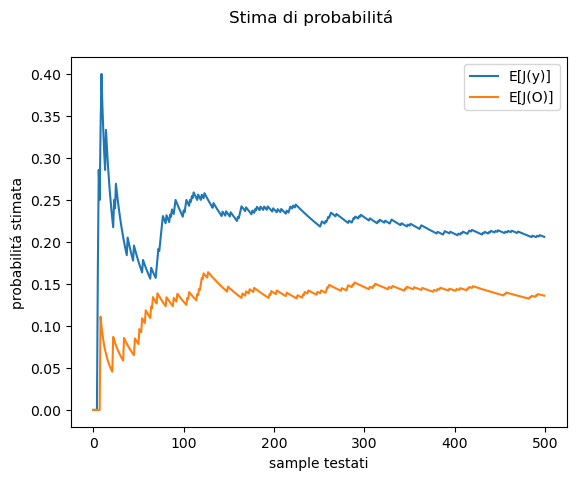

In [131]:
plt.suptitle("Stima di probabilitá")
plt.xlabel("sample testati")
plt.ylabel("probabilitá stimata")
plt.plot( np.cumsum(np.array(J))/(np.arange(len(J)) +1) )
plt.plot( np.cumsum(np.array(J_oracolo))/(np.arange(len(J_oracolo)) +1) )
plt.legend(['E[J(y)]','E[J(O)]'])
plt.show()

Possiamo anche visualizzare la stima per $\mathbb E[ \mathscr I(\hat y,\mathscr O) ]$

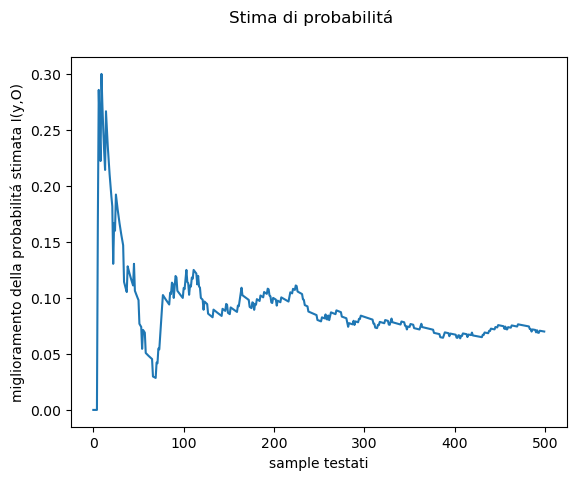

In [132]:
plt.suptitle("Stima di probabilitá")
plt.xlabel("sample testati")
plt.ylabel("miglioramento della probabilitá stimata I(y,O)")
plt.plot( np.cumsum(np.array(J)*1 - 1*np.array(J_oracolo))/(np.arange(len(J)) +1) )
plt.show()

# Average Amount of Attempts Test
Immaginiamo di avere una funzione $h_A : A \rightarrow \{0,1\}$ che restituisce $1$ se l'anchor point é quello piu vicino al punto di attachment, viceversa 0.
Testiamo quanti tentativi ci vogliono - mediamente - per trovare l'anchor point $a$ tale che $h_A(a) = 1$ usando rispettivamente la policy indotta dal nostro modello e la policy dell'oracolo casuale. (nella policy indotta dal modello partiamo da quelli predetti come piu vicini e li testiamo in ordine crescente, nella policy dell'oracolo casuale semplicemente tentiamo a caso)

In [127]:
def prediction_compare_oracolo(A,sample):
    classifica = np.random.choice(len(A),len(A),False)
    return np.c_[classifica, [ np.linalg.norm(c - A[c]) for c in classifica] ]

In [128]:
test_samples = np.arange(len(voxelizations))[indici_test]

tentativi           = []
tentativi_oracolo   = []
print("Stimando J(y) e J(O)...")
for i,sample in enumerate(test_samples[np.random.choice(len(test_samples),size = 100,replace = True)]):
    points      = prediction_compare(sample)
    points      = points.argsort(axis = 0)
    
    print(i)
    
    # riordino in funzione della predizione
    points      = points[points[:,0].argsort()]
    tentativi_curr =  ( (points[:,1] == 0).argmax() )
    tentativi.append(  (tentativi_curr * 1.) / len(points) )
    
    ############################################################
    
    points      = prediction_compare_oracolo(anchors[sample],sample)
    points      = points.argsort(axis = 0)

    # riordino in funzione della predizione
    points      = points[points[:,0].argsort()]
    tentativi_oracolo_curr =  ( (points[:,1] == 0).argmax() )
    tentativi_oracolo.append( (tentativi_oracolo_curr * 1.) / len(points) )
    
print("Stima eseguita.")

Stimando J(y) e J(O)...
-72.73882 23.829247
-55.05878 76.791016
-51.48491 206.04027
-52.235504 221.75195
-30.817244 85.7436
-52.31151 120.43947
-30.624847 261.29303
-20.899239 184.81265
-58.34578 402.6501
-27.762306 383.15503
-55.24999 101.471504
-39.609325 344.89157
-72.83647 11.71401
-53.590374 206.04115
-12.984485 396.66187
-64.57137 399.94028
-12.149692 306.8398
-20.043722 480.8803
0
-102.994064 181.54933
-79.72463 98.05774
-45.546 120.15805
-65.3057 17.156479
-127.243256 359.40326
-67.5378 388.37366
-43.343914 184.99268
-53.911114 411.25897
-58.828796 178.84323
-17.090305 292.21378
-35.45601 286.57248
-62.250336 379.13412
-81.15559 172.07114
-87.58275 101.01611
-34.3186 390.18378
-18.780025 395.7572
-18.746294 314.56885
-115.1087 129.72235
-41.804047 195.90991
1
-143.05476 10.3389225
-89.42514 149.21696
-118.05423 247.12408
-71.95741 60.43937
-110.597916 291.50952
-102.19747 389.1404
-83.76445 43.780914
-80.87515 153.62724
-85.55838 127.08336
-98.27066 334.45917
-45.448357 113.221

-48.38296 104.00697
-27.379839 73.08908
25
-74.93744 7.871686
-95.50677 249.2713
-102.63143 156.08351
-66.93318 162.89894
-61.644142 350.06854
-57.78393 130.79459
-42.702732 231.327
-74.11076 29.470089
-67.140366 111.16233
-18.800741 107.30698
-48.38296 104.00697
-27.379839 73.08908
26
-74.93744 7.871686
-95.50677 249.2713
-102.63143 156.08351
-66.93318 162.89894
-61.644142 350.06854
-57.78393 130.79459
-42.702732 231.327
-74.11076 29.470089
-67.140366 111.16233
-18.800741 107.30698
-48.38296 104.00697
-27.379839 73.08908
27
-28.03371 6.2056484
-30.63617 105.02576
-15.151497 91.22263
-4.0416703 290.76907
-48.70776 188.7847
-32.63451 274.13873
-21.892189 322.54007
-13.405136 52.093506
-1.3574703 108.26596
-14.42057 171.0231
9.374626 176.2221
11.930515 345.05573
-24.160414 186.74017
9.059818 237.26935
8.779412 139.11728
3.1021857 477.90906
-39.58538 44.100937
-9.8914795 313.70953
28
-88.13207 39.149456
-80.145164 114.23365
-118.272156 32.784203
-136.63391 117.743164
-92.31073 161.9595
-8

-47.580967 337.03076
48
-67.12128 28.146296
-17.067326 373.66653
-77.523224 13.998057
-75.02089 312.8159
-39.351467 272.43726
-40.71292 111.47253
-85.638016 571.7158
-59.476265 185.45546
-78.187836 109.8354
-45.12355 63.289154
-92.72185 176.66809
-56.246613 520.9524
-66.36865 293.3853
-27.93711 156.94157
-38.625977 300.37183
-24.374966 326.4784
-45.489265 460.07727
-60.105885 421.6704
-32.31771 343.73306
-42.211277 130.88152
-38.674183 166.84094
-19.169415 418.7243
-14.036232 515.5338
-20.573627 577.6542
-49.94793 375.0351
-12.3123255 332.9275
-37.026215 135.18301
1.356307 294.2236
-5.03907 128.46133
-1.955118 425.21454
-10.126785 345.39508
49
-63.965565 9.891721
-73.24741 101.9202
-48.386288 198.4513
-62.561386 155.23666
-72.103134 59.09314
-104.828476 333.9334
-75.71683 106.90706
-64.77049 246.5244
-45.40719 123.224304
-1.7124481 142.2127
-30.363014 299.42194
-29.476196 329.6026
-44.824085 174.02579
-16.21792 243.92776
-30.429264 279.36246
-36.56637 361.24475
50
-64.60923 4.904152
-6

-20.689728 212.17213
-53.53389 103.24367
-37.91249 158.56296
-26.62028 336.16824
8.460861 181.39241
-38.41275 214.84344
-45.734055 192.33545
-18.260689 292.57672
-35.524612 235.09744
72
-112.198975 15.805211
-67.19382 236.22845
-116.80001 22.536377
-80.17104 97.50316
-84.54628 120.92752
-107.79411 135.1991
-71.48485 85.74059
-139.0828 398.39325
-74.83525 264.30396
-74.25127 383.27863
-134.55545 281.5826
-58.07917 279.62347
-74.12579 299.12122
-106.370316 162.87405
-78.36438 511.44843
-39.38411 509.33057
-55.998665 438.9406
-2.7972593 271.25583
-71.5611 340.29718
-44.320393 145.0312
-57.809822 388.4013
-75.788574 270.756
-8.94374 242.29066
-42.832687 447.2259
73
-88.13207 39.149456
-80.145164 114.23365
-118.272156 32.784203
-136.63391 117.743164
-92.31073 161.9595
-85.76787 175.7215
-59.726418 170.90811
-77.70457 77.3431
-61.68815 200.11601
-81.70049 108.92617
-50.71866 147.7708
-70.95401 161.26665
-53.67034 120.44389
-124.740005 13.673232
74
-74.93744 7.871686
-95.50677 249.2713
-102.6

-63.965565 9.891721
-73.24741 101.9202
-48.386288 198.4513
-62.561386 155.23666
-72.103134 59.09314
-104.828476 333.9334
-75.71683 106.90706
-64.77049 246.5244
-45.40719 123.224304
-1.7124481 142.2127
-30.363014 299.42194
-29.476196 329.6026
-44.824085 174.02579
-16.21792 243.92776
-30.429264 279.36246
-36.56637 361.24475
94
-102.994064 181.54933
-79.72463 98.05774
-45.546 120.15805
-65.3057 17.156479
-127.243256 359.40326
-67.5378 388.37366
-43.343914 184.99268
-53.911114 411.25897
-58.828796 178.84323
-17.090305 292.21378
-35.45601 286.57248
-62.250336 379.13412
-81.15559 172.07114
-87.58275 101.01611
-34.3186 390.18378
-18.780025 395.7572
-18.746294 314.56885
-115.1087 129.72235
-41.804047 195.90991
95
-132.09209 4.1484885
-72.97062 157.22012
-67.808655 189.88292
-69.02463 238.20078
-56.653152 315.16138
-103.27094 145.1369
-113.57022 88.0568
-37.873383 108.39442
-46.832375 58.003647
-35.386726 184.36565
-40.646683 279.1733
96
-87.2836 4.6274304
-86.00989 133.15486
-91.76832 111.8116

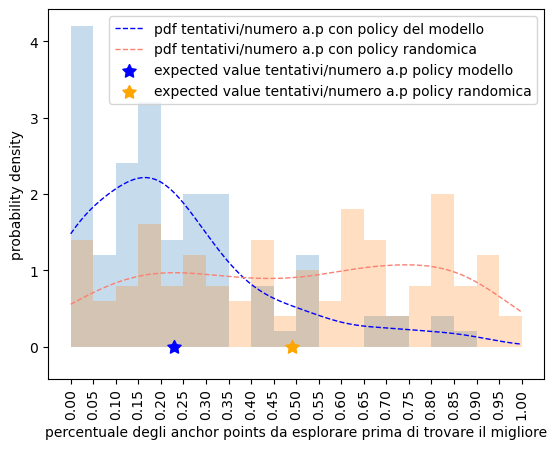

In [129]:
from scipy import stats
bins = np.linspace(0,1,21)
plt.xticks(bins,rotation = 90)
plt.hist(np.array(tentativi), alpha = 0.25, bins = bins , density = True)
plt.hist(tentativi_oracolo, alpha = 0.25, bins = bins, density = True)
kde = stats.gaussian_kde(tentativi)
xx = np.linspace(0, 1, 1000)
plt.plot(xx, kde(xx), '--', color = 'blue', lw = 1.)

kde = stats.gaussian_kde(tentativi_oracolo)
xx = np.linspace(0, 1, 1000)
plt.plot(xx, kde(xx),'--', color = 'salmon', lw = 1.)
plt.ylabel("probability density")
plt.xlabel("percentuale degli anchor points da esplorare prima di trovare il migliore")

plt.scatter( np.mean(tentativi), 0 , color = 'blue', marker = (5,1), s = 100)
plt.scatter( np.mean(tentativi_oracolo), 0 , color = 'orange', marker = (5,1), s = 100)

plt.scatter( (np.mean(tentativi_oracolo) + np.mean(tentativi))/2., -.2 , color = 'white') # dumb scatter point
plt.legend(['pdf tentativi/numero a.p con policy del modello',
            'pdf tentativi/numero a.p con policy randomica',
            'expected value tentativi/numero a.p policy modello',
            'expected value tentativi/numero a.p policy randomica'
           ])
plt.show()


In [26]:
W.shape

(30, 30, 30)